### 📌 算法介绍（Algorithm Description）

本代码实现了一个**图像旋转检测与自动对齐算法**，用于估计两个图像之间的旋转角度并对其进行几何校正。该流程在图像匹配、文档扫描校正、图像配准（registration）等任务中具有广泛应用。主要步骤如下：

1. **特征提取（ORB）**：利用 ORB（Oriented FAST and Rotated BRIEF）算法，从原图和旋转图中提取关键点和描述子，具备旋转不变性。
2. **特征匹配（Hamming + Cross-Check）**：使用 Brute-Force Matcher 对两个图像的描述子进行 Hamming 距离匹配，筛选前若干优质匹配点。
3. **估计仿射变换（RANSAC）**：用匹配点对估计部分仿射变换矩阵（仅包括旋转+平移+等比缩放），通过 RANSAC 去除离群点。
4. **提取旋转角度**：从仿射矩阵中提取旋转分量，计算出原图需旋转多少度以与目标图对齐。
5. **旋转校正**：根据计算出的角度对目标图进行逆向旋转，实现图像自动对齐。
6. **结果可视化**：并排展示原图、变形图和对齐图，直观呈现旋转校正效果。

------

以下是对你提出的图像处理与计算机视觉常用术语的系统解释：

------

### 🧩 ORB（Oriented FAST and Rotated BRIEF）

**ORB** 是一种高效的图像特征提取算法，由两部分组成：

- **FAST (Features from Accelerated Segment Test)**：用于快速检测图像中的关键点（例如角点）。
- **BRIEF (Binary Robust Independent Elementary Features)**：将每个关键点描述为一个二进制向量（称为描述子），便于后续匹配。
- **Oriented + Rotated**：在 ORB 中，BRIEF 被“旋转”以对关键点的方向进行归一化，从而具备**旋转不变性**（即图像旋转后特征描述不变）。

🧠 简单来说，ORB 是一种**快速、对旋转鲁棒、适合实时应用**的特征提取方法，常用于目标识别、图像拼接等任务中。

------

### 🧩 Brute-Force Matcher（暴力匹配器）

**Brute-Force Matcher** 是一种最基础的特征匹配方式，其思想是：

- 对图像 A 的每个描述子，在图像 B 中遍历所有描述子，计算距离；
- 选出最小距离的那一个作为“匹配结果”。

优点是**实现简单，匹配精度高**；缺点是**效率较低**，尤其在描述子数量多时。

------

### 🧩 Hamming 距离（汉明距离）

**Hamming 距离** 是二进制字符串之间的差异度量方式：

- 它表示两个等长字符串之间**对应位不同的位数**。

- 举例：

  ```
  A = 101010
  B = 100110
  Hamming distance = 2  （第3和4位不同）
  ```

ORB 使用的是二进制描述子（BRIEF），因此在匹配时用 Hamming 距离来度量两个描述子的相似度。**距离越小，匹配越好**。

------

### 🧩 仿射变换（Affine Transformation）

**仿射变换** 是一种保持图像中“平直性”和“比例关系”的几何变换，形式如下：

[x′y′]=[abcd][xy]+[txty]\begin{bmatrix} x' \\ y' \end{bmatrix} =  \begin{bmatrix} a & b \\ c & d \end{bmatrix} \begin{bmatrix} x \\ y \end{bmatrix} + \begin{bmatrix} t_x \\ t_y \end{bmatrix}

它包含了以下几种变换：

- 平移（Translation）
- 旋转（Rotation）
- 缩放（Scaling）
- 剪切（Shearing）

在图像配准中，我们常通过匹配点估计一个仿射变换矩阵，使两张图对齐。

------

### 🧩 RANSAC（Random Sample Consensus）

**RANSAC** 是一种鲁棒的模型拟合算法，用于在含有大量“离群点”（outliers）的数据中估计最优模型参数。步骤如下：

1. 随机选取少量样本（例如 4 对点）拟合一个模型；
2. 统计其他样本是否“内点”（inlier）；
3. 重复若干次，保留“内点数最多”的模型。

优点是：即使数据中有很多错误的点，也能找到正确的变换矩阵。

------

### 🧩 旋转分量（Rotation Component）

图像几何变换中，如果我们获得一个仿射矩阵：

M=[abtxcdty]M = \begin{bmatrix} a & b & t_x \\ c & d & t_y \end{bmatrix}

那么其左上角的 2×2 部分：

R=[abcd]R = \begin{bmatrix} a & b \\ c & d \end{bmatrix}

包含了“线性变换”的全部信息，其中的**旋转成分**可以通过以下公式提取：

θ=arctan⁡2(c,a)\theta = \arctan2(c, a)

这个角度表示坐标系绕中心点**逆时针旋转的角度**，用于旋转校正。

------

### 🧠 函数功能一览（Function Overview）

| 函数名                                                       | 说明                                                 |
| ------------------------------------------------------------ | ---------------------------------------------------- |
| `detect_and_compute(img_gray, n_features=2000)`              | 使用 ORB 从灰度图中提取关键点和描述子                |
| `match_features(des1, des2)`                                 | 使用 Hamming 距离进行暴力匹配，输出所有匹配结果      |
| `select_good_matches(matches, ratio=0.25, min_count=10, max_count=50)` | 选取匹配距离最小的一部分“好匹配”用于后续估计         |
| `estimate_affine_transform(kp1, kp2, matches)`               | 基于 RANSAC 从关键点对中估计仿射变换矩阵             |
| `extract_rotation_angle(M)`                                  | 从仿射矩阵提取旋转角度（单位为度）                   |
| `rotate_image(img, angle)`                                   | 将图像以中心点为原点逆时针旋转指定角度               |
| `visualize_results(img1, img2, img3, titles)`                | 可视化原图、目标图与对齐图                           |
| `calculate_rotation_for_loaded_images(...)`                  | 主调用函数，整合上述步骤，估算旋转角并展示对齐效果   |
| `create_dummy_images_for_testing(index_val)`                 | 用于生成带已知旋转角的测试图像（用于验证算法准确性） |


--- Test 1 --- True CCW angle: 0°


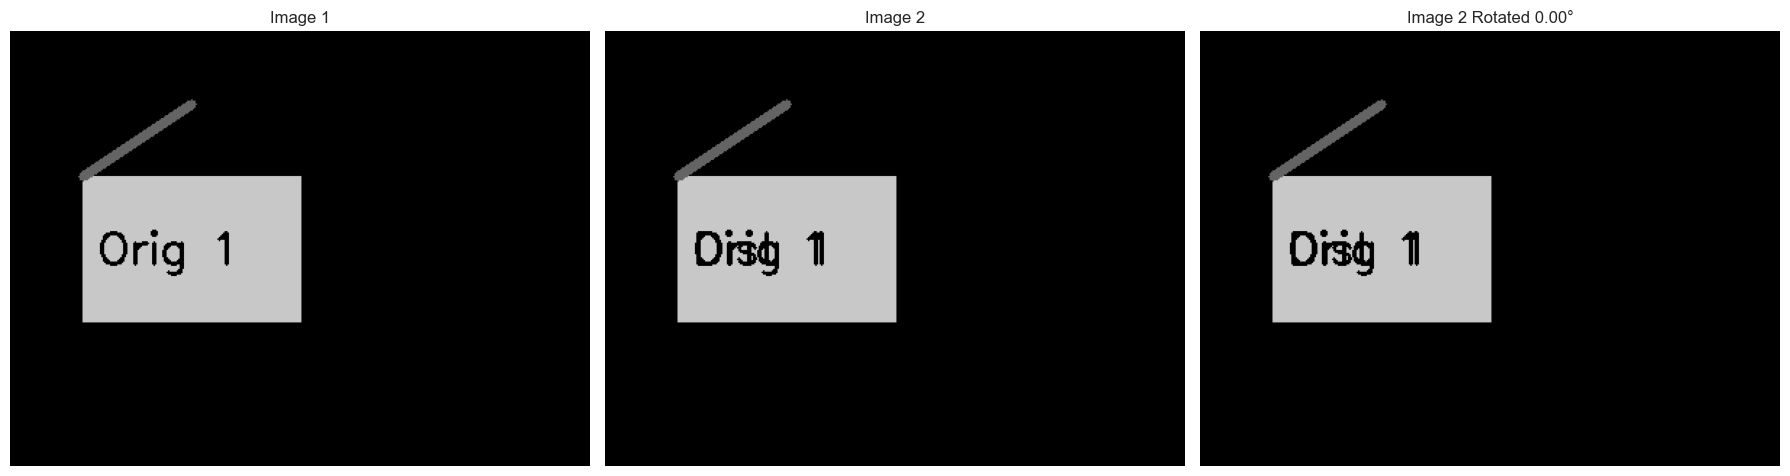

Estimated CCW rotation: 0.00°

--- Test 2 --- True CCW angle: 30°


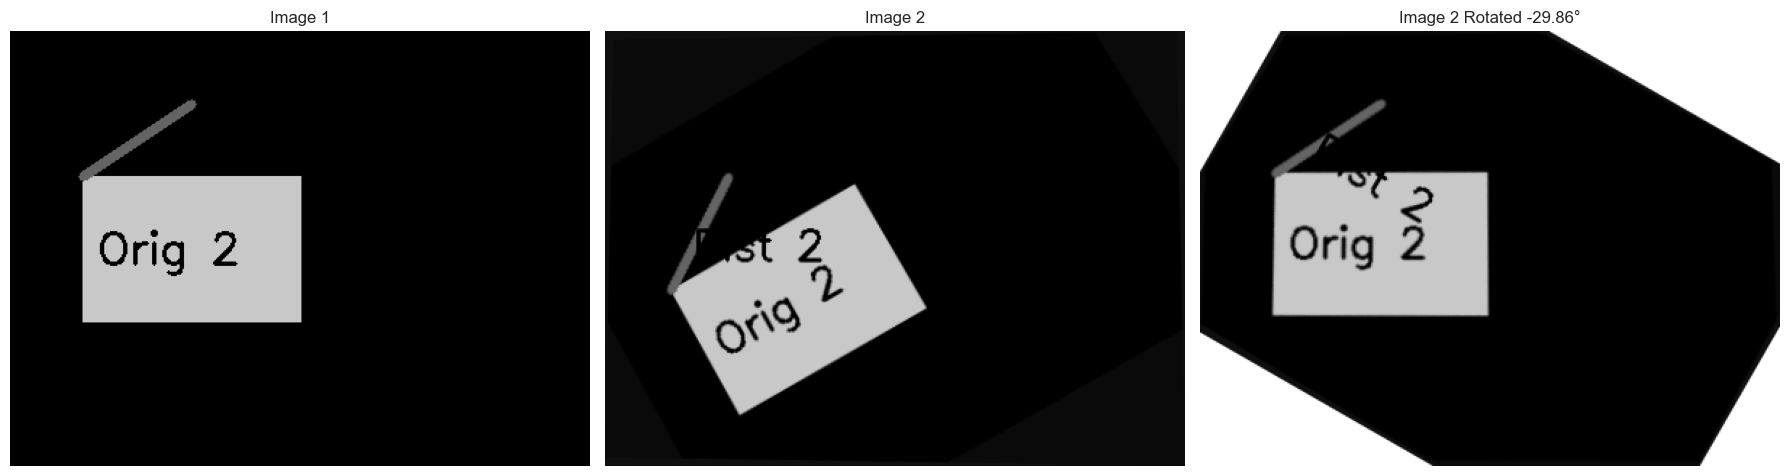

Estimated CCW rotation: -29.86°

--- Test 3 --- True CCW angle: -45°


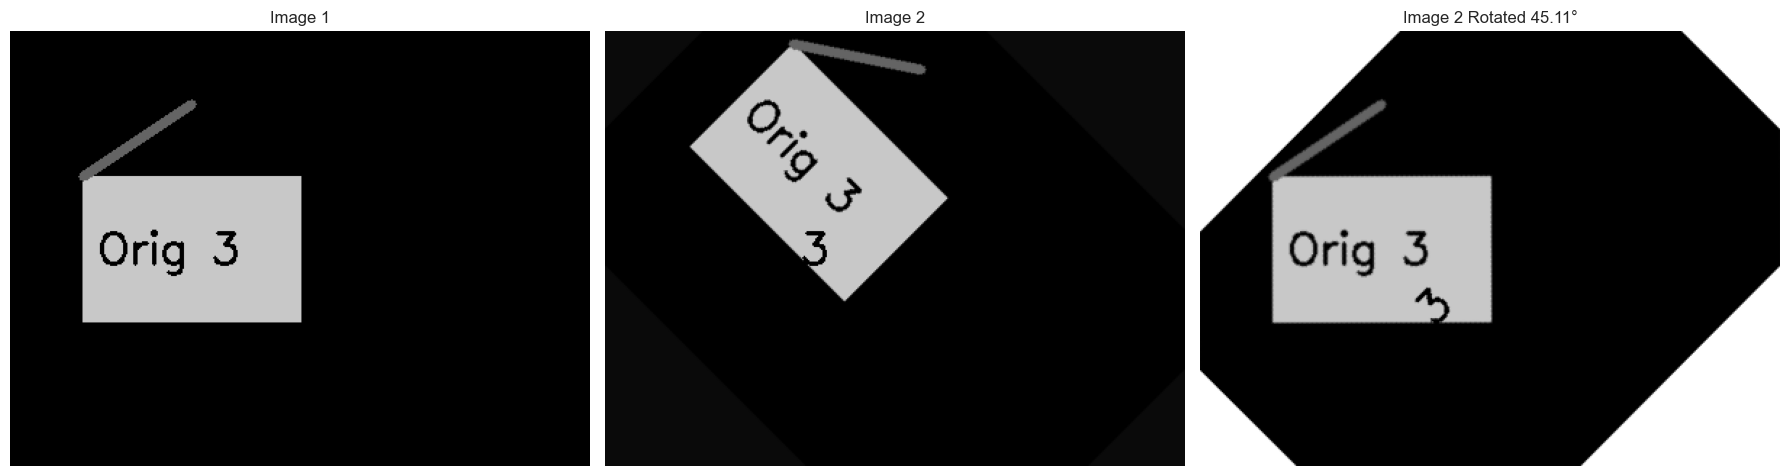

Estimated CCW rotation: 45.11°


In [ ]:
# version 0.1
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt

def detect_and_compute(img_gray, n_features=2000):
    orb = cv2.ORB_create(nfeatures=n_features)
    kp, des = orb.detectAndCompute(img_gray, None)
    return kp, des

def match_features(des1, des2):
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)
    return sorted(matches, key=lambda x: x.distance)

def select_good_matches(matches, ratio=0.25, min_count=10, max_count=50):
    num = int(min(max_count, max(min_count, len(matches) * ratio)))
    return matches[:num]

def estimate_affine_transform(kp1, kp2, matches):
    if len(matches) < 4:
        return None
    pts1 = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    pts2 = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
    M, _ = cv2.estimateAffinePartial2D(pts1, pts2, method=cv2.RANSAC)
    return M

def extract_rotation_angle(M):
    if M is None:
        return 0.0
    angle_rad = math.atan2(M[1, 0], M[0, 0])
    return math.degrees(angle_rad)

def rotate_image(img, angle):
    h, w = img.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    return cv2.warpAffine(img, M, (w, h), borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 255, 255))

def visualize_results(img1, img2, img3, titles):
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    for ax, im, title in zip(axes, (img1, img2, img3), titles):
        ax.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
        ax.set_title(title)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

def calculate_rotation_for_loaded_images(img1_gray, img2_gray, img1_bgr, img2_bgr):
    kp1, des1 = detect_and_compute(img1_gray)
    kp2, des2 = detect_and_compute(img2_gray)
    if des1 is None or des2 is None:
        return 0.0
    matches = match_features(des1, des2)
    good_matches = select_good_matches(matches)
    M = estimate_affine_transform(kp1, kp2, good_matches)
    angle = extract_rotation_angle(M)
    img3_bgr = rotate_image(img2_bgr, angle)
    visualize_results(img1_bgr, img2_bgr, img3_bgr, ['Image 1', 'Image 2', f'Image 2 Rotated {angle:.2f}°'])
    return angle

# 示例生成测试图像
def create_dummy_images_for_testing(index_val):
    base_img_gray = np.zeros((300, 400), dtype=np.uint8)
    cv2.rectangle(base_img_gray, (50, 100), (200, 200), 200, -1)
    cv2.line(base_img_gray, (50,100), (125,50), 100, 5)
    cv2.putText(base_img_gray, f"Orig {index_val}", (60, 160), cv2.FONT_HERSHEY_SIMPLEX, 1, 0, 2)

    test_angles = [0, 30, -45, 60, 190]
    angle = test_angles[(index_val -1) % len(test_angles)]
    rows, cols = base_img_gray.shape
    M_rot = cv2.getRotationMatrix2D((cols//2, rows//2), angle, 1.0)
    dist_img_gray = cv2.warpAffine(base_img_gray, M_rot, (cols, rows), borderValue=10)
    cv2.putText(dist_img_gray, f"Dist {index_val}", (60, 160), cv2.FONT_HERSHEY_SIMPLEX, 1, 0, 2)

    if index_val % 2 == 0:
        pts1 = np.float32([[0,0],[cols-1,0],[0,rows-1],[cols-1,rows-1]])
        shift = index_val * 3
        pts2 = np.float32([[shift,shift],[cols-1-shift,0],[0,rows-1-shift],[cols-1,rows-1]])
        M_persp = cv2.getPerspectiveTransform(pts1, pts2)
        dist_img_gray = cv2.warpPerspective(dist_img_gray, M_persp, (cols, rows), borderValue=15)

    orig_bgr = cv2.cvtColor(base_img_gray, cv2.COLOR_GRAY2BGR)
    dist_bgr = cv2.cvtColor(dist_img_gray, cv2.COLOR_GRAY2BGR)
    return base_img_gray, dist_img_gray, orig_bgr, dist_bgr, angle

for i in range(1, 4):
    orig_gray, dist_gray, orig_bgr, dist_bgr, true_angle = create_dummy_images_for_testing(i)
    print(f"\n--- Test {i} --- True CCW angle: {true_angle}°")
    angle = calculate_rotation_for_loaded_images(orig_gray, dist_gray, orig_bgr, dist_bgr)
    print(f"Estimated CCW rotation: {angle:.2f}°")


# my images
def ensure_bgr_from_gray(gray_img):
    """
    Convert a grayscale image to BGR format if needed.

    Args:
        gray_img (numpy.ndarray): Grayscale image (2D).

    Returns:
        numpy.ndarray: BGR image (3D) for display purposes.
    """
    if len(gray_img.shape) == 2:  # it's grayscale
        return cv2.cvtColor(gray_img, cv2.COLOR_GRAY2BGR)
    return gray_img  # already BGR


orig = cv2.imread('cc/original_shape_3.png', cv2.IMREAD_GRAYSCALE)
dist = cv2.imread('demo.images/distorted_shape_3.png', cv2.IMREAD_GRAYSCALE)

orig_bgr = ensure_bgr_from_gray(orig)
dist_bgr = ensure_bgr_from_gray(dist)

angle = calculate_rotation_for_loaded_images(orig, dist, orig_bgr, dist_bgr)


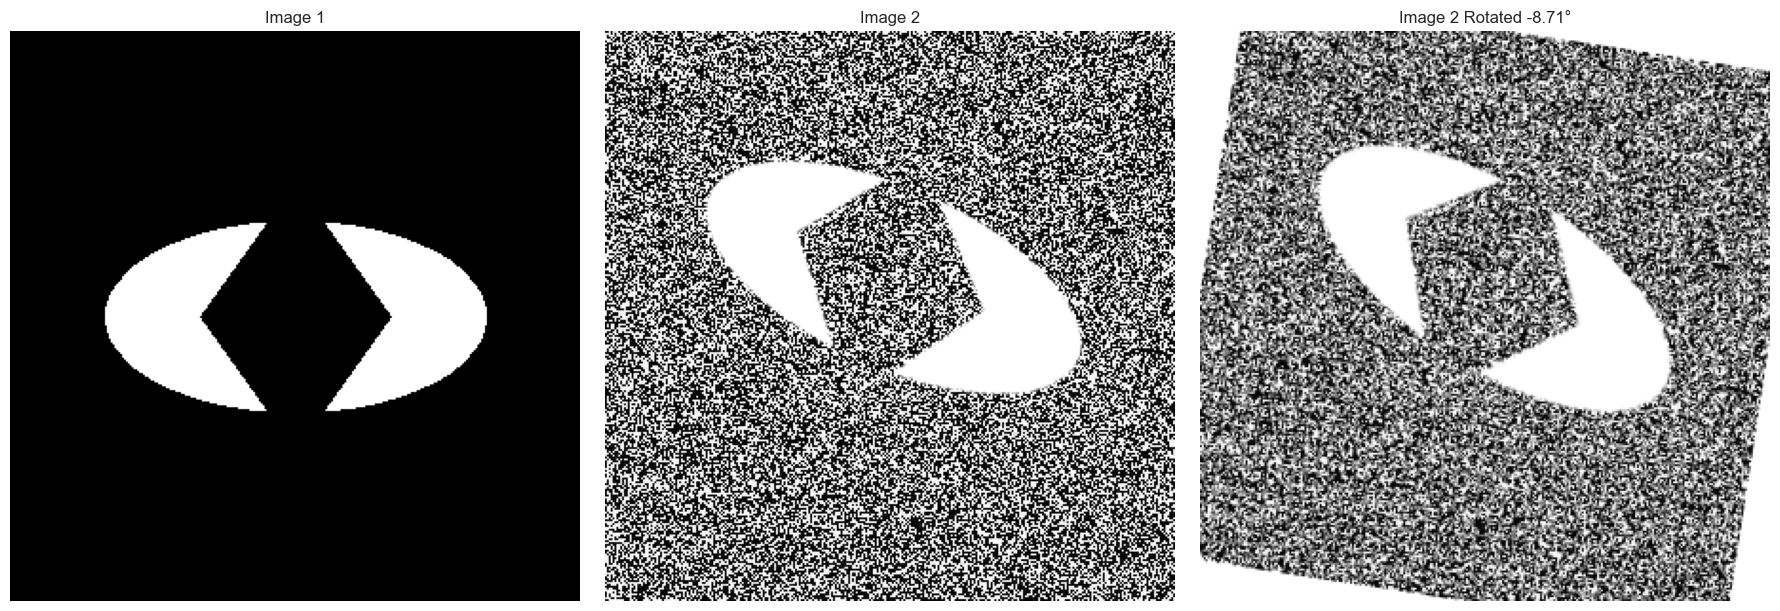

In [6]:
def ensure_bgr_from_gray(gray_img):
    """
    Convert a grayscale image to BGR format if needed.

    Args:
        gray_img (numpy.ndarray): Grayscale image (2D).

    Returns:
        numpy.ndarray: BGR image (3D) for display purposes.
    """
    if len(gray_img.shape) == 2:  # it's grayscale
        return cv2.cvtColor(gray_img, cv2.COLOR_GRAY2BGR)
    return gray_img  # already BGR


orig = cv2.imread('demo.images/original_shape_3.png', cv2.IMREAD_GRAYSCALE)
dist = cv2.imread('demo.images/distorted_shape_3.png', cv2.IMREAD_GRAYSCALE)

orig_bgr = ensure_bgr_from_gray(orig)
dist_bgr = ensure_bgr_from_gray(dist)

angle = calculate_rotation_for_loaded_images(orig, dist, orig_bgr, dist_bgr)


